## 10.2 注意力汇聚:Nadaraya-Waston核回归
上节我们介绍了框架下的注意力机制的主要成分图10.1.3：查询(自主提示)和键(非自主提示)之间的交互形成了注意力汇聚，注意力汇聚有选择地聚合了值(感官输入)以生成最终的输出。在本节中，我们将介绍注意力汇聚的更多细节，以便从宏观上了解注意力机制在实践中的运作方式。具体地说，1964年提出Nadaraya-Waston核回归模型是一个简单但完整的例子，可以用于演示具体注意力机制的机器学习

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

### 10.2.1 生成数据集
简单起见，考虑下面这个回归问题：给定的成对的“输入-输出”数据集$\{(x_1, y_1), ..., (x_n, y_n)\}$，如何学习$f$来预测任意新输入$x$的输出$\hat y = f(x)$?

根据下面的非线性函数生成一个人工数据集，其中加入的噪声项为$\epsilon$：
$$
y_i = 2 sin(x_i) + x_{i}^{0.8} + \epsilon,
\tag{10.2.1}
$$

其中$\epsilon$服从均值为0和标准差为0.5的正态分布。我们生成了50个训练样本和50个测试样本。为了更多地可视化之后的注意力模式，我们将训练样本进行排序。


In [4]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

def f(x):
    return 2 * torch.sin(x) + x ** 0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

下面的函数将绘制所有的训练样本(样本由圆圈表示)，不带噪声项的真实数据生成函数$f$(标记为“Truth”)，以及学习得到的预测函数(标记为“Pred”)

In [5]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
            xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

### 10.2.2 平均汇聚
我们先使用最简单的估计器来解决回归问题：基于平均汇聚来计算所有训练样本输出值的平均值：
$$
f(x) = \frac{1}{n} \sum_{i=1}^{n} y_i
\tag{10.2.2}
$$

如下图所示，这个估计器确实不够聪明：真实函数$f$("Truth")和预测函数("Pred")相差很大

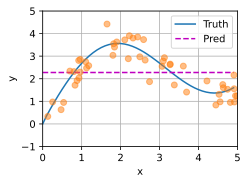

In [6]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

### 10.2.3 非参数注意力汇聚
显然，平均汇聚忽略了输入$x_i$。于是Nadaraya和Waston提出了一个更好的想法，根据输入的位置$y_i$进行加权:
$$
f(x) = \sum_{i=1}^{n} \frac{K(x - x_i)}{\sum_{j=1}^{n} K(x-x_j)} y_i
\tag{10.2.3}
$$

其中K是核(kernel)。公式(10.2.3)所描述的估计器被称为Nadaraya-Waston核回归(Nadaraya-Waston kernel regression)。这里我们不会深入讨论核函数的细节，但受此启发，我们可以从图10.1.3中的注意力机制框架的角度重写(10.2.3)，成为一个更加通用的注意力汇聚(attention pooling)公式：
$$
f(x) = \sum_{i=1}^{n} \alpha (x, x_i) y_i
\tag{10.2.4}
$$

其中$x$是查询，$(x_i, y_i)$是键值对。比较(10.2.4)和(10.2.2)，注意力汇聚是$y_i$的加权平均。将查询的$x$和键$x_i$之间的关系建模为注意力权重(attention weight) $\alpha (x, x_i)$，如(10.2.4)所示，这个权重将被分配给每个对应值$y_i$.对于任何查询，模型在所有键值对注意力权重都是一个有效的概率分布：他们是非负的，并且总和为1.

为了更好地理解注意力汇聚，我们考虑一个高斯核(Gaussian kernel)，其定义为：
$$
K(u) = \frac{1}{\sqrt{2\Pi}} exp(-\frac{u^2}{2})
\tag{10.2.5}
$$

将高斯核代入(10.2.4)和(10.2.3)可以得到
$$
\begin{align*}
f(x) & = \sum_{i=1}^{n} \alpha (x, x_i)y_i\\
& = \sum_{i=1}^{n} \frac{exp(-\frac{1}{2}(x-x_i)^2)}{\sum_{j=1}^{n} exp(-\frac{1}{2}(x-x_j)^2)} y_i\\
& = \sum_{i=1}^n softmax(-\frac{1}{2} (x- x_i)^2) y_i
\tag{10.2.6}
\end{align*}

$$